# Introduction 

# Project Overview
This project involves an intricate series of steps, encompassing data collection from reputable sources, integration of diverse datasets into a coherent framework, exploratory data analysis to uncover trends and relationships, and predictive modeling techniques to forecast future global temperature anomalies. Additionally, the study entails the comparison of these predictions with established climate models, intending to shed light on potential accelerated warming trends observed in recent climate features.

This project aims to delve into a comprehensive examination of climate data across an extensive timeline, ranging from 800,000 years ago to the present day. The analysis primarily focuses on establishing correlations between CO2 levels and temperature anomalies while also exploring changes in polar ice coverage as a key variable. This research also seeks to investigate climate change signals within the context of Ireland's meteorological observations and harnesses data fusion techniques to amalgamate multiple datasets into a structured pandas dataframe.

In [59]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import sys 
from sklearn.impute import SimpleImputer
import random
from plotly.offline import iplot
from plotnine import ggplot, aes, geom_line, geom_bar, geom_point, labs, coord_flip, theme_xkcd, geom_smooth
import json 
import warnings 


# Introduction 
This project aims to explore the topic of climate change and show the corralations between CO2 levels polar ice and rainfall as the key variables, This research also seeks to investigate climate change signals within the context of Ireland's meteorological observations and harnesses data fusion techniques to amalgamate multiple datasets into a structured pandas dataframe.

# polar ice

Polar Ice. form part of the debate on climate change, Polar ice arises when sea water freezes, polar Ice covers 7% of the earths surface and it also covers 12% of the worlds oceans and according to According to the National Snow Ice and Data Center (NSIDC), sea ice covers just over 9.6 million square miles of the Earth. That's about 2.5 times the size of Canada!. Polar ice helps to regulate heat. It insulates the relatively warm ocean water from the cold polar atmosphere except where cracks, or leads, in the ice allow exchange of heat and water vapor from ocean to atmosphere in winter. The number of leads determines where and how much heat and water are lost to the atmosphere, which may affect local cloud cover and precipitation. As sea ice extent shrinks and breaks up, exposed ocean waters increase.

In 1979, satellites started monitoring sea ice, to keep an eye on how much of it there was. This has raised alarm NSIDC reported that in January 2017, there was about 5.17 million square miles of Arctic sea ice recorded. This was the lowest recorded amount since 1979. In fact, it's 100,000 square miles less Arctic sea ice than there was in January 2016.

This means that as this ice begins to melt and disapper water levels will begin to rise and this gives rise to flooding. Warmer temperatures in the Arctic and the Antarctic can also affect how the world's atmosphere behaves, as air moves around the Earth. There is one other factor at play here the question of wildlife, Polar bears seals penguins all need this ice to live. if it disappers and reduces year and year. they are also at risk. 



In [60]:
seaice = pd.read_csv('data/seaice.csv') #reading in the seaice dataset


In [61]:
seaice.info() #checking the info on dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26354 entries, 0 to 26353
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          26354 non-null  int64  
 1    Month        26354 non-null  int64  
 2    Day          26354 non-null  int64  
 3        Extent   26354 non-null  float64
 4       Missing   26354 non-null  float64
 5    Source Data  26354 non-null  object 
 6   hemisphere    26354 non-null  object 
dtypes: float64(2), int64(3), object(2)
memory usage: 1.4+ MB


In [62]:
southern = seaice[seaice.iloc[:,6]=='south'] #taking only the information from the south hempisphere

In [63]:
years_list = list(southern['Year'].value_counts().index)
years_list = sorted(years_list)

In [64]:

warnings.simplefilter(action='ignore')
def by_months(southern):    
    s_months = 3 + ((2019-1979) * 12) + 5 
    seaice_monthly = pd.DataFrame(columns=['Year', 'Month', 'Extent'], index=range(s_months))
    i = 0
    for year in years_list:
        
        if year == 1978:
            months_list = range(10,13)
        elif year == 2019:
            months_list = range(1,6)
        else:
            months_list = range(1,13)

        for month in months_list:
            subset = southern[southern['Year']==year][southern.iloc[:,1]==month]
            monthly_mean = np.mean(subset.iloc[:,3])
            seaice_monthly.iloc[i] = [year, month, monthly_mean]
            i += 1

    return seaice_monthly

seaice_clean = by_months(southern)

In [65]:
seaice_clean.head()

,Year,Month,Extent
0,1978,10,17.699
1,1978,11,15.8964
2,1978,12,10.39525
3,1979,1,5.4022
4,1979,2,3.141071


In [66]:
seaice_clean.tail()

,Year,Month,Extent
483,2019,1,3.831323
484,2019,2,2.656214
485,2019,3,3.164161
486,2019,4,5.708633
487,2019,5,8.835516


In [67]:
def anomaliesSIE(seaice):
  #Calcule mean by months from 1981-2010
  df_30y = seaice.query('1981 <= Year <= 2010')
  df_30y = df_30y.reset_index().drop(['index'], axis=1)
  mean_30y = []
  for m in range(1,13):
    mu = seaice[seaice.Month == m]['Extent'].mean()
    mean_30y.append(mu)

  #Compute SIE anomalies
  anomalies_list = []
  for s in range(0, len(seaice)):
    mean_30y_index = seaice.loc[s, 'Month']-1
    #Calcule anomalies
    anomalies_SIE = seaice.loc[s, 'Extent'] - mean_30y[mean_30y_index]
    anomalies_SIE = anomalies_SIE/mean_30y[mean_30y_index]*100
    #Save anomalies
    anomalies_list.append(anomalies_SIE)
  seaice['AnomaliesSIE'] = anomalies_list
  return seaice, mean_30y

df_SIE, mean_30y = anomaliesSIE(seaice_clean)
df_SIE.head()

,Year,Month,Extent,AnomaliesSIE
0,1978,10,17.699,-2.349663
1,1978,11,15.8964,0.285111
2,1978,12,10.39525,-0.402900
3,1979,1,5.4022,8.505038
4,1979,2,3.141071,2.580231


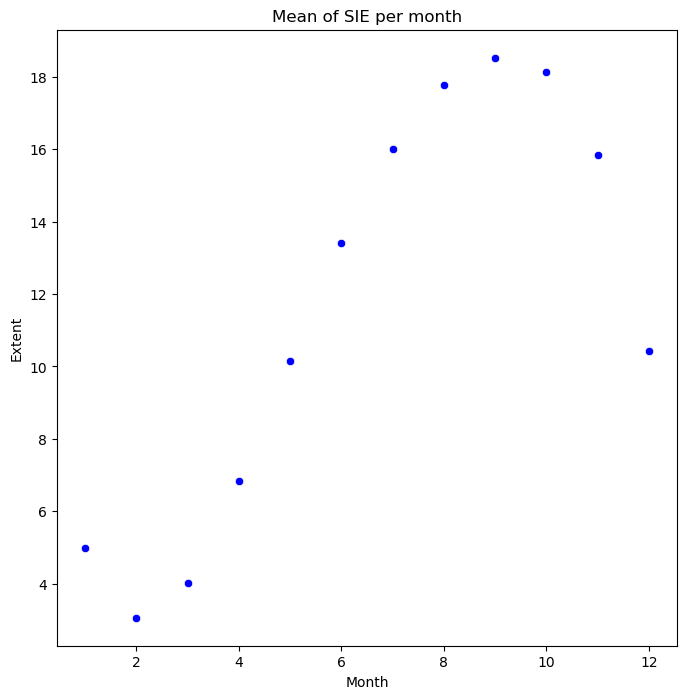

In [68]:
mean_years = []
std_dict = {}
for m in range(1,13):
  #Calcule mu and std values
  mu = seaice_clean[seaice_clean.Month == m]['Extent'].mean()
  std = seaice_clean[seaice_clean.Month == m]['Extent'].std()
  #Save mu and std values
  mean_years.append(mu)
  std_dict[m] = std
df_mean_years = pd.DataFrame(mean_years)
df_mean_years['Month'] = range(1, 13)
df_mean_years.columns = ['Extent', 'Month']
plt.figure(figsize=(8, 8))
sns.scatterplot(x='Month', y='Extent', data=df_mean_years,  color='blue', sizes=20).set(title='Mean of SIE per month')
plt.show()

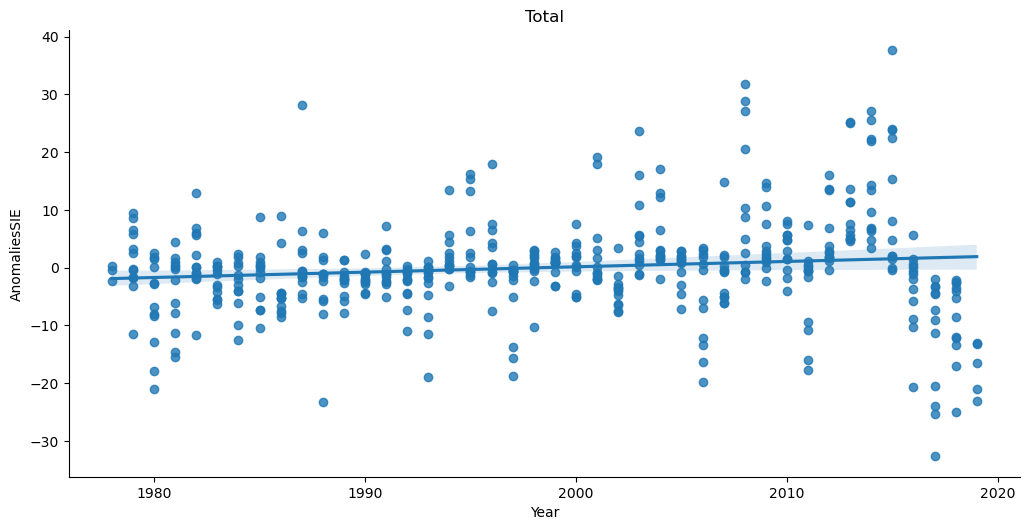

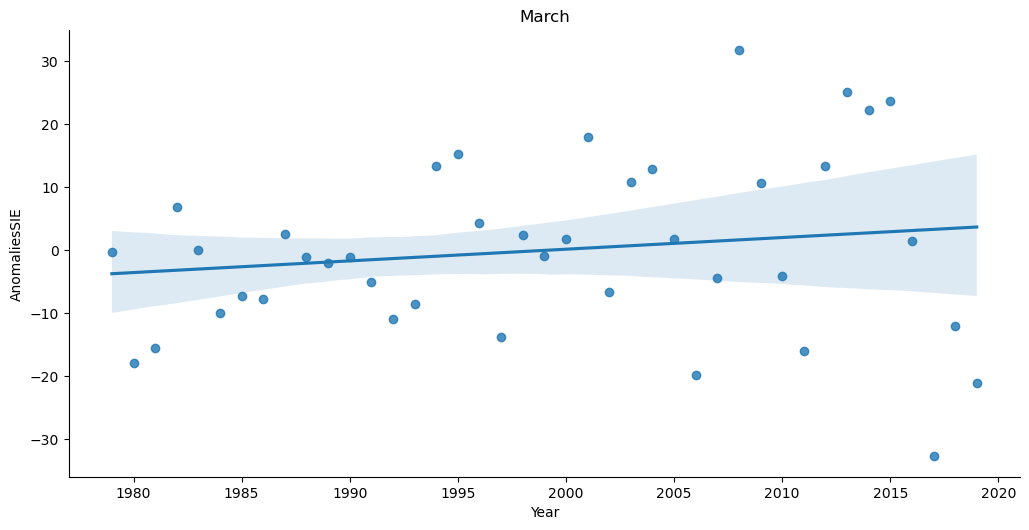

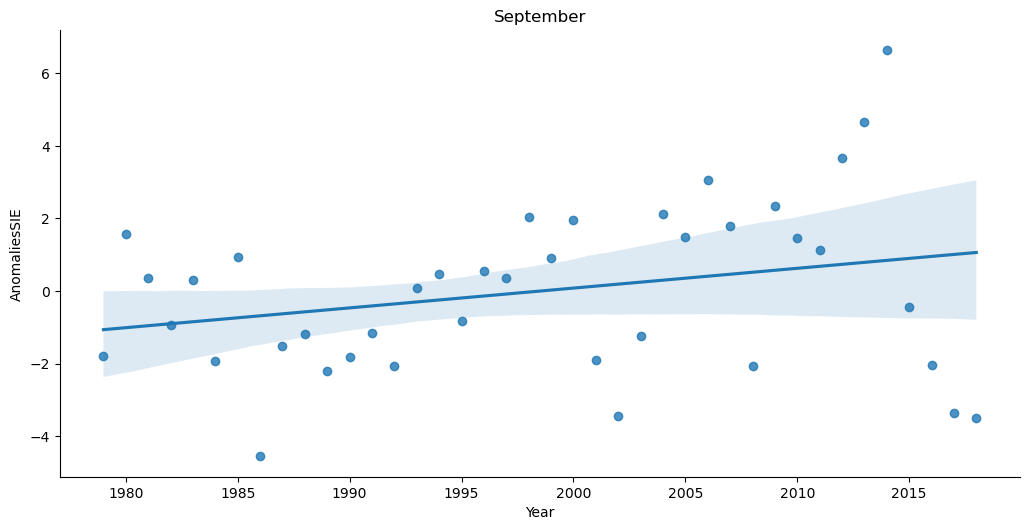

In [69]:
df_SIE['Year'] = pd.to_numeric(df_SIE['Year'])

sns.lmplot(x='Year', y='AnomaliesSIE', data=df_SIE, height=5.2, aspect=2).set(title='Total')
plt.show()
sns.lmplot(x='Year', y='AnomaliesSIE', data=df_SIE[df_SIE.Month == 3], height=5.2, aspect=2).set(title='March')
plt.show()
sns.lmplot(x='Year', y='AnomaliesSIE', data=df_SIE[df_SIE.Month == 9], height=5.2, aspect=2).set(title='September')
plt.show()

In [71]:
seaice_mean = []
std_dict = {}
for y in range(1978, 2019):
  #Calcule mu and std values
  mu = seaice_clean[seaice_clean.Year == y]['Extent'].mean()
  std = seaice_clean[seaice_clean.Year == y]['Extent'].std()
  #Save mu and std values
  seaice_mean.append(mu)
  std_dict[y] = std

seaice_mean

[14.66355,
 11.653818799603174,
 11.205945386904764,
 11.387509375,
 11.59415625,
 11.343461656746031,
 11.428565972222222,
 11.569727033730159,
 11.043747321428574,
 11.663671010944702,
 11.403143389015737,
 11.379158659754225,
 11.363856458013315,
 11.498326849718383,
 11.3742313403782,
 11.371259594214031,
 11.726791327444957,
 11.748205709165385,
 11.744542936596218,
 11.340793477982592,
 11.690445378904252,
 11.711689784946236,
 11.72303360524039,
 11.628243740399384,
 11.174099404761904,
 11.924078443420377,
 11.938545528982822,
 11.647807136456734,
 11.413619028417818,
 11.637005792370713,
 12.215347225312074,
 11.99790855094726,
 12.05638342293907,
 11.449442780337941,
 11.980925132863673,
 12.474902112135176,
 12.725776433691754,
 12.365620929339478,
 11.178465863304908,
 10.701842524321558,
 10.889444130824373]

In [90]:
years_seaice = list(range(1978, 2019))

seaice_mean = pd.DataFrame({'year': years_seaice, 'sea_ice': seaice_mean})
seaice_mean.sea_ice = seaice_mean.sea_ice.round(2)
seaice_mean.to_csv("df_seaice_mean.csv", encoding='utf-8', index=False)


# rainfall in Ireland 

Over the years the question I have pondered and many people living on the island of Ireland is 'I have never experinced weather this warm in Ireland' Is this global warming or just the odd burst of sunshine? 

wikipedia states 'Rainfall is the most common form of precipitation on the island, and is extremely common throughout Ireland, although some parts of the west coast receive twice as much rain as the east coast. Rainfall in Ireland normally comes from Atlantic frontal systems which travel northeast over the island, bringing cloud and rain. Most of the eastern half of the country has between 750 and 1,000 mm (29.5 and 39.4 in) of rainfall in the year' 

In [91]:
Irish_rainfall = pd.read_csv('data/rainfall_ireland.csv') #loading in dataset 

In [92]:
Irish_rainfall.head() # looking at the start of the dataset

,Year,Month,Rainfall
0,1711,1,16.4
1,1711,2,73.1
2,1711,3,121.2
3,1711,4,85.2
4,1711,5,66.6


In [93]:
Irish_rainfall.tail() # looking at the end of dataset

,Year,Month,Rainfall
3667,2016,8,79.1
3668,2016,9,108.1
3669,2016,10,51.8
3670,2016,11,58.0
3671,2016,12,92.1


In [94]:
Irish_rainfall.info() #seeing information on the dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 0 to 3671
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      3672 non-null   int64  
 1   Month     3672 non-null   int64  
 2   Rainfall  3672 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 86.2 KB


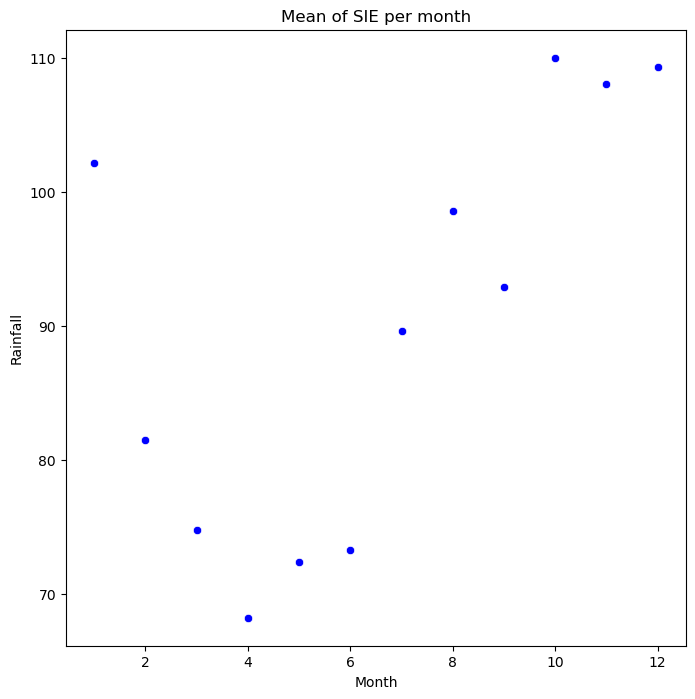

In [95]:
mean_years = []
std_dict = {}
for m in range(1,13):
  #Calcule mu and std values
  mu = Irish_rainfall[Irish_rainfall.Month == m]['Rainfall'].mean()
  std = Irish_rainfall[Irish_rainfall.Month == m]['Rainfall'].std()
  #Save mu and std values
  mean_years.append(mu)
  std_dict[m] = std
df_mean_years = pd.DataFrame(mean_years)
df_mean_years['Month'] = range(1, 13)
df_mean_years.columns = ['Rainfall', 'Month']
plt.figure(figsize=(8, 8))
sns.scatterplot(x='Month', y='Rainfall', data=df_mean_years,  color='blue', sizes=20).set(title='Mean of SIE per month')
plt.show()

In [96]:
def anomaliesSIE(Irish_rainfall):
  
  df_300y = Irish_rainfall.query('1711 <= Year <= 2016')
  df_300y = df_300y.reset_index().drop(['index'], axis=1)
  mean_300y = []
  for m in range(1,13):
    mu = Irish_rainfall[Irish_rainfall.Month == m]['Rainfall'].mean()
    mean_300y.append(mu)

  
  anomalies_list = []
  for s in range(0, len(Irish_rainfall)):
    mean_300y_index = Irish_rainfall.loc[s, 'Month']-1
    
    anomalies_SIE = Irish_rainfall.loc[s, 'Rainfall'] - mean_300y[mean_300y_index]
    anomalies_SIE = anomalies_SIE/mean_300y[mean_300y_index]*100
    
    anomalies_list.append(anomalies_SIE)
  Irish_rainfall['AnomaliesSIE'] = anomalies_list
  return Irish_rainfall, mean_300y

df_SIE, mean_300y = anomaliesSIE(Irish_rainfall)
df_SIE.head()

,Year,Month,Rainfall,AnomaliesSIE
0,1711,1,16.4,-83.947182
1,1711,2,73.1,-10.270409
2,1711,3,121.2,62.083071
3,1711,4,85.2,24.939857
4,1711,5,66.6,-7.927099


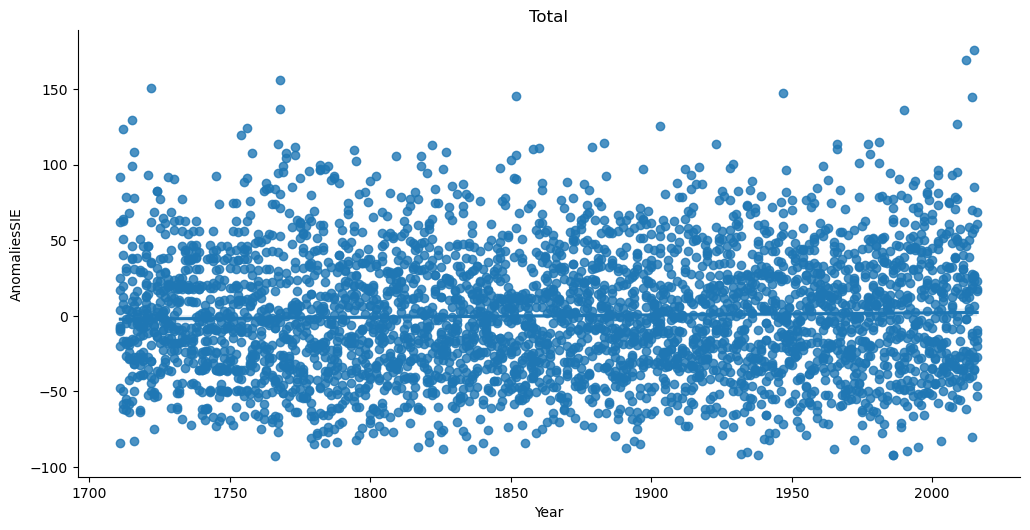

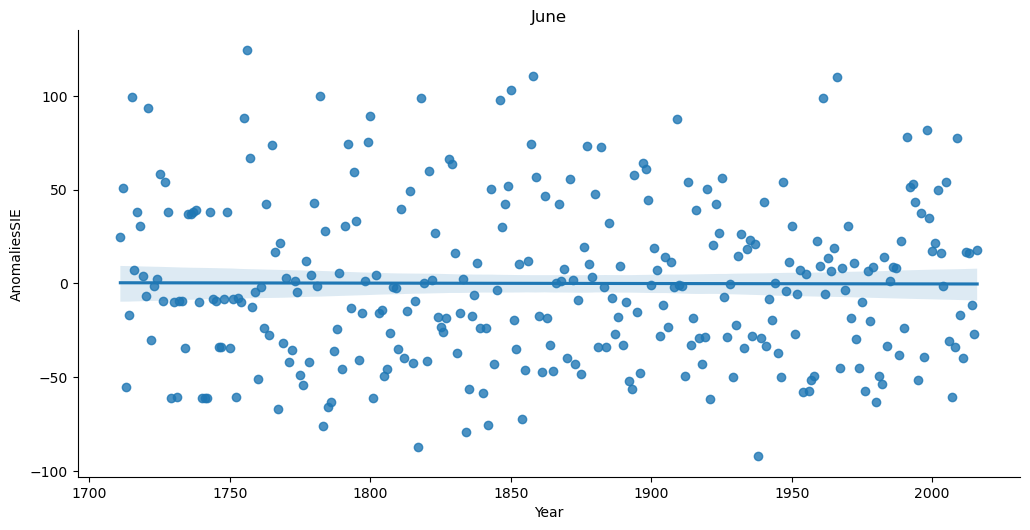

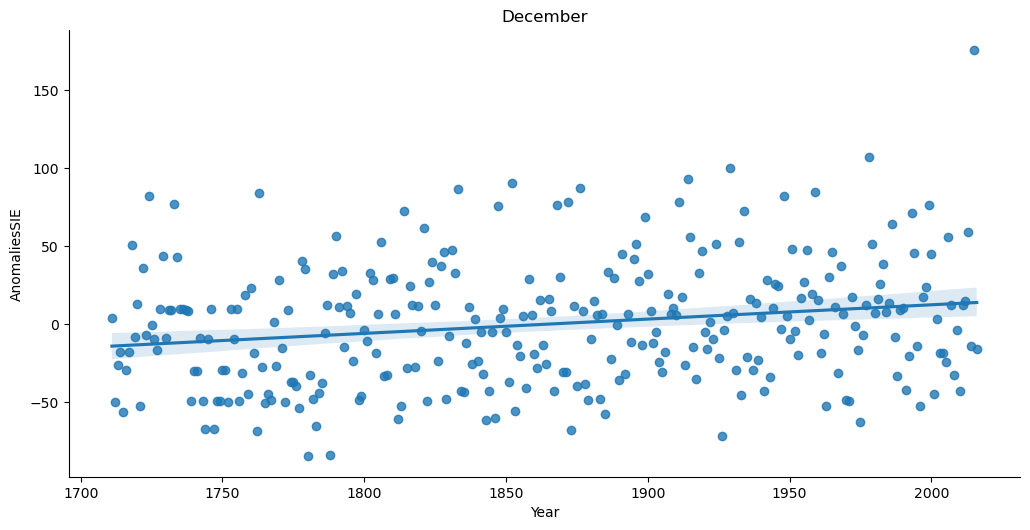

In [97]:
df_SIE['Year'] = pd.to_numeric(df_SIE['Year'])
sns.lmplot(x='Year', y='AnomaliesSIE', data=df_SIE, height=5.2, aspect=2).set(title='Total')
plt.show()
sns.lmplot(x='Year', y='AnomaliesSIE', data=df_SIE[df_SIE.Month == 4], height=5.2, aspect=2).set(title='June')
plt.show()
sns.lmplot(x='Year', y='AnomaliesSIE', data=df_SIE[df_SIE.Month == 12], height=5.2, aspect=2).set(title='December')
plt.show()

# CO2 

The average temperature at the Earth's surface has risen about 1.1C since 1850. Carbon dioxide is Earth’s most important greenhouse gas: a gas that absorbs and radiates heat. Unlike oxygen or nitrogen (which make up most of our atmosphere), greenhouse gases absorb heat radiating from the Earth’s surface and re-release it in all directions—including back toward Earth’s surface. Without carbon dioxide, Earth’s natural greenhouse effect would be too weak to keep the average global surface temperature above freezing. Carbon dioxide concentrations are rising mostly because of the fossil fuels that people are burning for energy.

The CO2 data being analysed is a composite dataset derived from Antartic ice cores. The dataset spans over a timeframe of 800,000 years before the present (yrBP) to the year 2001, where 1950 is the present date. This composite, presented by Bereiter et al. in 2014, revises the earlier Lüthi et al. (2008) version. The atmospheric CO2 concentrations is measured in parts per million by volume (ppmv) at various points in time. The age unit is measured in years before present.

In [98]:
co2_data = pd.read_excel('data/new_atmospheric_CO2.xls', sheet_name='CO2 Composite', skiprows=range(14))
co2_data.head()

,Gasage (yr BP),CO2 (ppmv),sigma mean CO2 (ppmv)
0,-51.030000,368.022488,0.060442
1,-48.000000,361.780737,0.370000
2,-46.279272,359.647793,0.098000
3,-44.405642,357.106740,0.159923
4,-43.080000,353.946685,0.043007


In [99]:
co2_data.columns = co2_data.columns.str.strip()
# Extract relevant columns.
co2_df = co2_data[['Gasage (yr BP)', 'CO2 (ppmv)']]

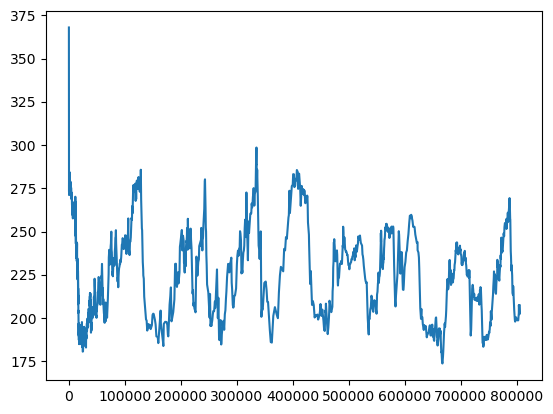

In [100]:
plt.plot(co2_data['Gasage (yr BP)'], co2_data['CO2 (ppmv)'])

# Mauna Loa CO2 Data
The Mauna Loa data has the the latest anthropogenic data. Since 1958, the atmospheric carbon dioxide (CO2) concentration measurements were collected at the Mauna Loa Observatory in Hawaii. The observatory is in prime location to sample the Earths air. It is situated on the side of Mauna Loa, the world’s largest active volcano. The observatory is approximately 3,400 meters above sea level and remains a long distance away from significant pollution sources. This means the air is relatively clean. The Mauna Loa Observatory allows scientists to understand the ongoing increase in greenhouse gas concentrations. The measurements are essential for assessing the impact of human-induced climate change on the Earth's atmosphere. National Oceanic and Atmospheric Administration (NOAA) maintained the dataset.

In [101]:
mauna_loa_data = pd.read_csv('data/mlo_data.csv',
                             skiprows = [i for i in range(1, 44)])


In [102]:
mauna_loa_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    21 non-null     int64  
 1   mean    21 non-null     float64
 2   unc     21 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 636.0 bytes


In [103]:
mauna_loa_data.head()

,year,mean,unc
0,2002,373.45,0.12
1,2003,375.98,0.12
2,2004,377.70,0.12
3,2005,379.98,0.12
4,2006,382.09,0.12


In [104]:
mauna_loa_data.tail()

,year,mean,unc
16,2018,408.72,0.12
17,2019,411.65,0.12
18,2020,414.21,0.12
19,2021,416.41,0.12
20,2022,418.53,0.12


In [177]:

reference_year = 1950
mauna_loa_data['Gasage (yr BP)'] = reference_year - mauna_loa_data['year']


mauna_loa_data['Gasage (yr BP)'] = mauna_loa_data['Gasage (yr BP)'].astype(float)


mauna_loa_data = mauna_loa_data.rename(columns=({'mean':'CO2 (ppmv)'}))

mlo_data = mauna_loa_data[['Gasage (yr BP)', 'CO2 (ppmv)']]

In [178]:
merged_data = pd.concat([mlo_data, co2_df[['Gasage (yr BP)', 'CO2 (ppmv)']]])

# Temperature

In [179]:
temp_df = pd.read_excel('data/epicaDC.deuttemp.EDC3-AICC.xls')
temp_df.head()

,bag,ztop,EDC3béta,AICC2012,deutfinal,temp,acc-EDC3beta
0,1,0.00,-50.00000,-55.000000,NaN,218.3,3.105321
1,2,0.55,-43.55977,-50.513333,NaN,218.3,3.104805
2,3,1.10,-37.44019,-46.026667,NaN,218.3,3.104404
3,4,1.65,-31.64156,-41.540000,NaN,218.3,3.104025
4,5,2.20,-24.55278,-34.516667,NaN,218.3,3.103453


In [180]:
temp_df = pd.read_excel('data/epicaDC.deuttemp.EDC3-AICC.xls')

In [181]:
temp_df = temp_df.rename(columns=({'EDC3béta':'Gasage (yr BP)'}))


# CH4 Data

In [182]:
columns = ['Depth', 'Gas Age', 'CH4 Mean', '1s', 'Lab']

ch4_data = pd.read_csv("data/edc-ch4-2008.txt", skiprows=154, delim_whitespace=True, names=columns, engine='python')

ch4_data.head()

,Depth,Gas Age,CH4 Mean,1s,Lab
0,99.34,13,907,10.0,b
1,102.45,126,784,10.0,g
2,102.58,130,762,10.0,b
3,103.34,151,710,10.0,g
4,104.33,184,727,10.0,g


In [183]:
ch4_data = ch4_data.rename(columns=({'Gas Age':'Gasage (yr BP)'}))

ch4_df = ch4_data[['Gasage (yr BP)', 'CH4 Mean']]

In [184]:
mlo_CH4_data = pd.read_csv('data/ch4_annmean_gl.csv')
mlo_CH4_data.head()

,year,mean,unc
0,1984,1644.85,0.67
1,1985,1657.29,0.59
2,1986,1670.09,0.74
3,1987,1682.70,0.49
4,1988,1693.28,0.67


In [185]:
reference_year = 1950
mlo_CH4_data['Gasage (yr BP)'] = reference_year - mlo_CH4_data['year']


mlo_CH4_data['Gasage (yr BP)'] = mlo_CH4_data['Gasage (yr BP)'].astype(float)

mlo_CH4_data = mlo_CH4_data.rename(columns=({'mean':'CH4 Mean'}))

mlo_ch4_df =mlo_CH4_data[['Gasage (yr BP)', 'CH4 Mean']]

In [186]:
merged_CH4_data = pd.concat([mlo_ch4_df, ch4_df[['Gasage (yr BP)', 'CH4 Mean']]])